# **Import and Functions**

In [145]:
import numpy as np
import pandas as pd
import cv2
import matplotlib
import pywt
import os # Used to create directories
import shutil # Used to remove existing directories
import seaborn as sn

from matplotlib import pyplot as plt
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report 

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

%matplotlib inline

## **Locations**

In [146]:
# OpenCV
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/OpenCV/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/OpenCV/haarcascade_eye.xml")

# Paths
dataset_path = "/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Datasets"
cropped_dataset_path = "/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset"

# Test Images
test_image_1 = "/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Test_Images/sharapova1.jpg"
test_image_2 = "/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Test_Images/sharapova2.jfif"

## **Helper Functions**

In [147]:
def get_face(image_path):
  '''Given an image path, it returns the cropped face from the image, if correctly detected, else returns None'''
  color_image = cv2.imread(image_path)
  gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

  for (x, y, w, h) in faces:
    gray_interest_region = gray_image[y: y + h, x: x + w]
    color_interest_region = color_image[y: y + h, x: x + w]
    eyes = eye_cascade.detectMultiScale(gray_interest_region)

    if len(eyes) >= 2:
      return color_interest_region

In [148]:
def wavelet_transform(image, mode = "haar", level = 1):
  '''Transforms an image into its wavelet using the haar cascade (used for face and eye detection)'''
  image_Array = image

  # Datatype conversion (converting to grayscale)
  image_Array = cv2.cvtColor(image_Array, cv2.COLOR_RGB2GRAY)

  # Convert to float
  image_Array = np.float32(image_Array)
  image_Array /= 255;
  
  # Compute coefficients
  coefficients = pywt.wavedec2(image_Array, mode, level = level)


  #Process Coefficients
  coefficients_Haar = list(coefficients)
  coefficients_Haar[0] *= 0


  # Reconstruction
  image_Array_Haar = pywt.waverec2(coefficients_Haar, mode)
  image_Array_Haar *= 255;
  image_Array_Haar = np.uint8(image_Array_Haar)

  return image_Array_Haar

# **Data Preparation**

## **Data Preprocessing**

Using **Haar Cascade** for Face and Eye detection.

Article: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

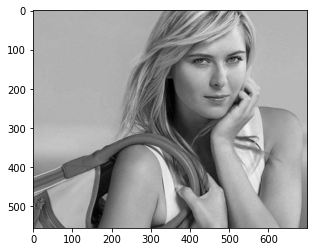

In [149]:
color_image = cv2.imread(test_image_1)
# color_image.shape -> (555, 700, 3) : (height, width, RGB colors)
# plt.imshow(color_image) -> color image view

gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
# gray_image.shape -> (555, 700)
plt.imshow(gray_image, cmap = "gray")

**Face Detection**

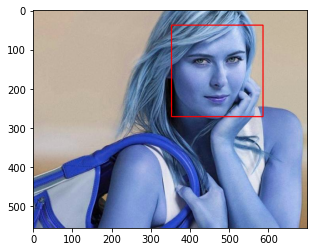

In [150]:
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
# faces -> array([[352,  38, 233, 233]], dtype=int32)
'''
  (x, y, width, height) : Starting point of the face
'''

(x, y, w, h) = faces[0]
# (x, y, w, h) -> (352, 38, 233, 233)

face_image = cv2.rectangle(color_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
# (255, 0, 0): red
plt.imshow(face_image)


**Eye Detection**

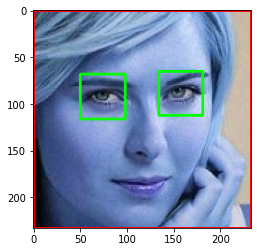

In [151]:
cv2.destroyAllWindows()

for (x, y, w, h) in faces:
  face_image = cv2.rectangle(color_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
  gray_interest_region = gray_image[y: y + h, x: x + w]
  color_interest_region = face_image[y: y+ h, x: x + w]
  eyes = eye_cascade.detectMultiScale(gray_interest_region)

  for (ex, ey, ew, eh) in eyes:
    cv2.rectangle(color_interest_region, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2) # Green

plt.figure()
plt.imshow(face_image, cmap = "gray") # Complete image with highlighted face and eyes

plt.imshow(color_interest_region, cmap = "gray") # cropped face image with highlighted eyes


In [152]:
face_image = np.array(color_interest_region)
# face_image.shape -> (233, 233, 3)

## **Wavelet**

Wavelet Transformed images give clues on facial features, such as eyes, nose, lips, etc. (A shaper image)

This along with raw pixel image stacked vertically toghether will be the input to our classifier.

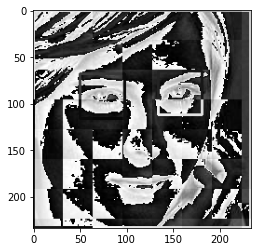

In [153]:
image_harr = wavelet_transform(face_image, "db1" , 5)
plt.imshow(image_harr, cmap = "gray")

## **Directories**

In [154]:
import os
image_directories = []
for entry in os.scandir(dataset_path):
  if entry.is_dir():
    image_directories.append(entry.path)

image_directories

['/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Datasets/maria_sharapova',
 '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Datasets/lionel_messi',
 '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Datasets/virat_kohli',
 '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Datasets/serena_williams',
 '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Datasets/roger_federer']

### **Cropped Images**

In [155]:
if os.path.exists(cropped_dataset_path):
  shutil.rmtree(cropped_dataset_path)
os.mkdir(cropped_dataset_path)

cropped_image_directories = []
celebrity_file_name_dictionary = {}

for image_directory in image_directories:
  count = 1
  celebrity_name = image_directory.split("/")[-1]
  celebrity_file_name_dictionary[celebrity_name] = []

  for entry in os.scandir(image_directory):
    color_interest_region = get_face(entry.path)
    if color_interest_region is not None:
      cropped_folder = cropped_dataset_path + "/" + celebrity_name
      if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)
        cropped_image_directories.append(cropped_folder)
        print("Generating cropped image in folder: ", cropped_folder)
      cropped_file_name = celebrity_name + str(count) + ".png"
      cropped_file_path = cropped_folder + "/" + cropped_file_name
      cv2.imwrite(cropped_file_path, color_interest_region)

      celebrity_file_name_dictionary[celebrity_name].append(cropped_file_path)
      count += 1


Generating cropped image in folder:  /content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova
Generating cropped image in folder:  /content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/lionel_messi
Generating cropped image in folder:  /content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/virat_kohli
Generating cropped image in folder:  /content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/serena_williams
Generating cropped image in folder:  /content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/roger_federer


Next Step: Manually Examine Cropped Folder and delete any unwanted images.

In [156]:
celebrity_file_name_dictionary = {}

for image_directory in cropped_image_directories:
  celebrity_name = image_directory.split("/")[-1]
  files_list = []
  for entry in os.scandir(image_directory):
    files_list.append(entry.path)
  celebrity_file_name_dictionary[celebrity_name] = files_list

celebrity_file_name_dictionary

{'maria_sharapova': ['/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova1.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova2.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova3.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova4.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova5.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova6.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharapova/maria_sharapova7.png',
  '/content/drive/MyDrive/Colab Notebooks/CelebrityClassifier/Datasets/Cropped_Dataset/maria_sharap

In [157]:
labels = {}

count = 0

for celebrity_name in celebrity_file_name_dictionary.keys():
  labels[celebrity_name] = count
  count += 1

labels

{'maria_sharapova': 0,
 'lionel_messi': 1,
 'virat_kohli': 2,
 'serena_williams': 3,
 'roger_federer': 4}

### **Preparing X and y**

In [158]:
X, y = [], []

for celebrity_file_names, training_files in celebrity_file_name_dictionary.items():
  for training_image in training_files:
    image = cv2.imread(training_image)
    scaled_original_image = cv2.resize(image, (32, 32))
    image_harr = wavelet_transform(image, "db1", 5)
    scaled_image_harr = cv2.resize(image_harr, (32, 32))

    combined_image = np.vstack((scaled_original_image.reshape(32 * 32 * 3, 1), scaled_image_harr.reshape(32 * 32, 1)))
    
    X.append(combined_image)
    y.append(labels[celebrity_file_names])

# len(X[0]) -> 4096

X = np.array(X).reshape(len(X), 4096).astype(float)
# X.shape -> (142, 4096)


# **Model Selection and Building**

**SVM with "rbf" kernel with heuristic finetuning**

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel = "rbf", C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.8333333333333334

In [160]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.86      0.92         7
           2       0.82      1.00      0.90         9
           3       0.71      0.83      0.77         6
           4       0.50      0.50      0.50         4

    accuracy                           0.83        36
   macro avg       0.81      0.80      0.80        36
weighted avg       0.85      0.83      0.84        36



## **Grid Search CV**

In [161]:
model_parameters = {
    "svm" : {
        "model" : svm.SVC(gamma = "auto", probability = True),
        "params" : {
            "svc__C" : [1, 10, 100, 1000],
            "svc__kernel" : ["rbf", "linear"]
        }
    },
    "random_forest" : {
        "model" : RandomForestClassifier(),
        "params" : {
            "randomforestclassifier__n_estimators" : [1, 5, 10]
        }
    },
    "logistic_regression" : {
        "model" : LogisticRegression(solver = "liblinear", multi_class = "auto"),
        "params" : {
            "logisticregression__C" : [1, 5, 10]
        }
    }
}

In [162]:
scores = []
best_estimators = {}

for algorithm, model_param in model_parameters.items():
  pipe = make_pipeline(StandardScaler(), model_param["model"])
  clf = GridSearchCV(pipe, model_param["params"], cv = 5, return_train_score = False)
  clf.fit(X_train, y_train)
  scores.append({
      "model" : algorithm,
      "best_score" : clf.best_score_,
      "best_params" : clf.best_params_
  })

  best_estimators[algorithm] = clf.best_estimator_


dataframe = pd.DataFrame(scores, columns = ["model", "best_score", "best_params"])
dataframe

,model,best_score,best_params
0,svm,0.802165,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.651948,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.822078,{'logisticregression__C': 1}


In [163]:
best_estimators
# best_estimators["svm"].score(X_test, y_test) -> 0.8888888888888888
# best_estimators["random_forest"].score(X_test, y_test) -> 0.75
# best_estimators["logistic_regression"].score(X_test, y_test) -> 0.8611111111111112

best_clf = best_estimators["svm"]

### **Confusion Matrix**

Text(69.0, 0.5, 'Truth')

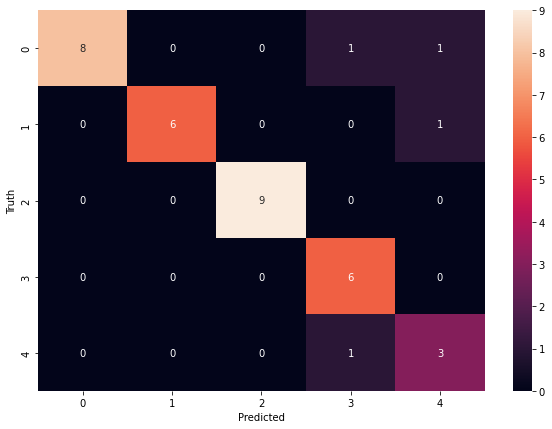

In [164]:
conf_matrix = confusion_matrix(y_test, best_clf.predict(X_test))
# confusion_matrix
plt.figure(figsize = (10, 7))
sn.heatmap(conf_matrix, annot = True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

# **Model Export**

In [165]:
!pip install joblib

import joblib
joblib.dump(best_clf, "celebrityClassifier_model.pkl")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['celebrityClassifier_model.pkl']

**Saving Class Dictionary**

In [166]:
import json
with open("celebrityLabels.json", "w") as f:
  f.write(json.dumps(labels))